In [1]:
from tensorflow.keras import Sequential,Model
from tensorflow.keras.applications import InceptionResNetV2,VGG19
from keras.layers import *
import keras.backend as K

In [2]:
vgg_cl = VGG19()
vgg_cl.trainable = False
vgg_cl.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
model_ph = Sequential([
    Conv2D(64,(3,3),padding="same",activation="relu"),
    Conv2D(64,(3,3),padding="same",activation="relu",strides=(2,2)), # 112 112 64
    Conv2D(256,(3,3),padding="same",activation="relu"),
    Conv2D(256,(3,3),padding="same",activation="relu",strides=(2,2)),# 56 56 256
    Conv2D(512,(3,3),padding="same",activation="relu"),
    Conv2D(512,(3,3),padding="same",activation="relu",strides=(2,2)), # 28 28 512
])
model_out = Sequential([
    Input((28, 28, 514),1),
    UpSampling2D((2,2)), # 56,56,514
    Conv2D(128,(3,3),padding="same",activation="relu"),
    UpSampling2D((2,2)), # 112 112 128
    Conv2D(64,(3,3),padding="same",activation="relu"),
    Conv2D(32,(3,3),padding="same",activation="relu"),
    Conv2D(2,(3,3),padding="same",activation="tanh"),
    UpSampling2D((2,2)), # 224 224 2
])


In [4]:
inp = Input((224,224,1),1)
inp_for_vgg = concatenate([inp,inp,inp])
out_vgg_cl = vgg_cl(inp_for_vgg) # 1 1000
out_ph_model = model_ph(inp) # 28 28 512


concatenate_vgg_zero = concatenate([
    out_vgg_cl,
    K.constant([[0 for _ in range(568)]for _ in range(out_vgg_cl.shape[0])],dtype=float)
])
concatenate_vgg_re = Reshape((28,28,2))(concatenate_vgg_zero)

concatenate_vgg_ph = concatenate([concatenate_vgg_re,out_ph_model]) # 28 28 514


output = model_out(concatenate_vgg_ph)


model = Model(inp,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(1, 224, 224, 1)]   0           []                               
                                                                                                  
 concatenate (Concatenate)      (1, 224, 224, 3)     0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 vgg19 (Functional)             (None, 1000)         143667240   ['concatenate[0][0]']            
                                                                                              

In [5]:
from data_preparation import *
x,ab,rgb = create_data_imagenet()
x.shape,ab.shape,rgb.shape

((1, 224, 224, 1), (1, 224, 224, 2), (224, 224, 3))

In [36]:
model.compile(optimizer="adam",
             loss='mse',
             metrics=['accuracy'])
model.fit(x,ab,epochs=50)

Epoch 1/150
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - accuracy: 0.9182
Epoch 2/150
1/1 [==============================] - 0s 445ms/step - loss: 0.0061 - accuracy: 0.0790
Epoch 3/150
1/1 [==============================] - 0s 443ms/step - loss: 0.0065 - accuracy: 0.6251
Epoch 4/150
1/1 [==============================] - 0s 429ms/step - loss: 0.0033 - accuracy: 0.1373
Epoch 5/150
1/1 [==============================] - 0s 433ms/step - loss: 0.0034 - accuracy: 0.8483
Epoch 6/150
1/1 [==============================] - 0s 440ms/step - loss: 0.0027 - accuracy: 0.7257
Epoch 7/150
1/1 [==============================] - 0s 451ms/step - loss: 0.0033 - accuracy: 0.1236
Epoch 8/150
1/1 [==============================] - 0s 450ms/step - loss: 0.0028 - accuracy: 0.3247
Epoch 9/150
1/1 [==============================] - 0s 431ms/step - loss: 0.0024 - accuracy: 0.9029
Epoch 10/150
1/1 [==============================] - 0s 434ms/step - loss: 0.0022 - accuracy: 0.9093
Epoch 11/150

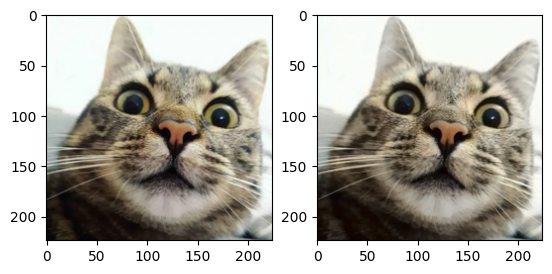

In [37]:
res = lab_ab_in_rgb(x,ab)
rgb = np.array(rgb,dtype=int)
plt.subplot(1, 2, 1)
print(np.min(rgb))
plt.imshow(rgb)

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.show()

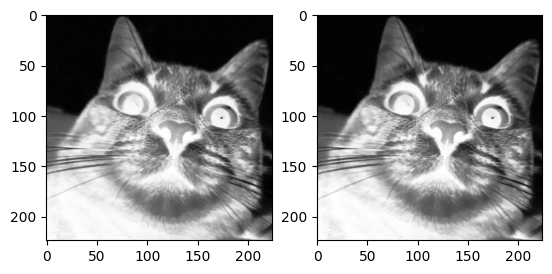

(1, 224, 224, 3)